# A Gentle Introduction to Transfer Learning for Image Classification

According to [Andrew Ng](http://www.andrewng.org/), cofounder of Coursera and Adjunct Professor at Stanford, Transfer Learning will be the next driver of Machine Learning commercial success.

[Transfer Learning](http://cs231n.github.io/transfer-learning/) is a Machine Learning technique that allows to reutilize an already trained convolutional neural network (CNN) on a specific dataset and adapt it, or transfer it, to a different dataset. The reason you want to reuse a trained CNN is because it typically takes a long time to train. For example, training [ResNet18](https://arxiv.org/abs/1512.03385) for 30 epochs in 4 NVIDIA K80 GPU [took us 3 days](https://blogs.technet.microsoft.com/machinelearning/2016/11/15/imagenet-deep-neural-network-training-using-microsoft-r-server-and-azure-gpu-vms/). Training ResNet152 for 120 epochs in 4 NVIDIA K80 GPUs takes 4 months. 

In this post we will use [PyTorch](https://github.com/pytorch/pytorch/) to perform transfer learning in different datasets. We will explain the most common strategies to perform transfer learning and we will analyze when you should use each of them. 

**If you want to go directly to the results, scroll to the bottom of the notebook.**

## Transfer learning strategies

In general, there are two strategies to perform transfer learning, and I have not seen a final agreement on the naming. **Finetuning**, which consists of using the pretrained network on the base dataset and train all layers in the target dataset, and **freeze and train**, which consists of leaving all but the last layer frozen (the weights are not updated) and train the last layer. It is also possible to freeze the first couple of layers and finetune the rest, this is due to some evidence indicating that the first layers of the CNN contains [texture filters and color blobs](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf). However, in this work we are going to analyze the two extreme cases: training all layers and training only the last layer.

The most common base dataset is [ImageNet](http://image-net.org/), which contains 1.2 million images with 1000 categories. These categories are divided in two big groups, animals and objects. The number of images per category is around 1000. Most deep learning libraries provide CNN models pretrained on ImageNet.  

The image below shows the workflow of a CNN architecture, i.e. ResNet, identifying a cat. The input is an image of 224x224px and 3 channels (RGB), and the output is the label `tabby cat`. The last layer has 1000 units, corresponding to the 1000 classes of ImageNet.
![ResNet CNN](./img/resnet.svg)

In the image below we can see the two mentioned strategies for transfer learning. Here we used a pretrained CNN on ImageNet and adapt it to classify Homer Simpson, using as the target dataset a subset of [the Simpsons Character Data](https://www.kaggle.com/alexattia/the-simpsons-characters-dataset). This subset contains 20 classes with between 300 and 1000 images per class. 

The first step to perform transfer learning is to adapt the number of classes from the base dataset to the target dataset. In the case of the Simpsons dataset, we have to remove the last layer of the network, which contains 1000 units and add a new layer with 20 units. 

Then we can use **freeze and train**, as it is represented in the upper figure, and just train the last layer, or we can **finetune** all layers, as it is represented in the bottom figure.
![Transfer Learning](./img/finetuning_freezing.svg)

## When to use transfer learning

It is difficult to know in which cases one should just train the last layer or finetune the network. In [(Yosinsky et. al., 2014)](http://arxiv.org/abs/1411.1792), the authors address the problem of quantifying the degree to which a particular CNN layer is general or specific in the context of the ImageNet dataset. They found that the the transferability is negatively affected by splitting the network in the middle layers due to coadaptation of these layers. They reported that the transferability gap grows as the distance between tasks increases and finally, they found that initializing the network with transferred weights can improve generalization performance in comparison with training it from zero weights.

As reported in this [tutorial of Karpathy](http://cs231n.github.io/transfer-learning/), these are some guidelines of the different scenarios when using transfer learning in a new dataset:
* **Small and similar images**: When the target dataset is small in comparison with the base dataset and its images are very different, the recommendation is to freeze and train the last layer.
* **Large and similar images**: When the dataset is large and it has similar images the recommendation is finetune. 
* **Small and different images**: In this case the recommendation is freeze and train the last layer or some of the last layers
* **Large and different images**: In this case the recommendation is finetune.

In this notebook, we are going to revisit these strategies using different datasets.



In [3]:
import os
import sys
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import lr_scheduler, SGD
from torchvision import models
torch.backends.cudnn.benchmark=True # enables cudnn's auto-tuner

from utils import (
    get_gpu_name, 
    get_number_processors, 
    plot_pytorch_data_stream, 
    train_model, 
    create_dataset, 
    available_models, 
    plot_metrics, 
    download_hymenoptera
)

print(f"OS: {sys.platform}")
print(f"Python: {sys.version}")
print(f"PyTorch: {torch.__version__}")
print(f"Numpy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Number of CPU processors: {get_number_processors()}")
print(f"GPU: {get_gpu_name()}")

%matplotlib inline
%reload_ext autoreload
%autoreload 2

OS: linux
Python: 3.12.3 (main, Jan 22 2026, 20:57:42) [GCC 13.3.0]
PyTorch: 2.10.0+cu128
Numpy: 2.4.2
Pandas: 3.0.1
Number of CPU processors: 24
GPU: ['NVIDIA GeForce RTX 5090 Laptop GPU']


## Model and utilities

The first step is to define the `finetune` and `freeze_and_train` routines. In addition, we list all the models avaialable in pytorch that we could potentially use as a base model.

In [4]:
model_names = available_models()
print(model_names)

['alexnet', 'convnext_base', 'convnext_large', 'convnext_small', 'convnext_tiny', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'efficientnet_v2_l', 'efficientnet_v2_m', 'efficientnet_v2_s', 'get_model', 'get_model_builder', 'get_model_weights', 'get_weight', 'googlenet', 'inception_v3', 'list_models', 'maxvit_t', 'mnasnet0_5', 'mnasnet0_75', 'mnasnet1_0', 'mnasnet1_3', 'mobilenet_v2', 'mobilenet_v3_large', 'mobilenet_v3_small', 'regnet_x_16gf', 'regnet_x_1_6gf', 'regnet_x_32gf', 'regnet_x_3_2gf', 'regnet_x_400mf', 'regnet_x_800mf', 'regnet_x_8gf', 'regnet_y_128gf', 'regnet_y_16gf', 'regnet_y_1_6gf', 'regnet_y_32gf', 'regnet_y_3_2gf', 'regnet_y_400mf', 'regnet_y_800mf', 'regnet_y_8gf', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'resnext101_32x8d', 'resnext101_64x4d', 'resnext50_32x4d', 'shufflenet_v2_x0_

In [ ]:
def finetune(dataloaders, model_name, sets, num_epochs, num_gpus, lr, momentum, lr_step, lr_epochs, verbose=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #Class adaptation
    num_class = len(dataloaders[sets[0]].dataset.class_to_idx)
    model_ft = models.__dict__[model_name](weights="DEFAULT")
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_class)
    
    #gpus
    if num_gpus > 1 and torch.cuda.device_count() > 1: 
        model_ft = nn.DataParallel(model_ft)
    model_ft = model_ft.to(device)
    
    #loss
    criterion = nn.CrossEntropyLoss()

    # All parameters are being optimized
    optimizer = SGD(model_ft.parameters(), lr=lr, momentum=momentum)

    # Decay LR by a factor of lr_step every lr_epochs epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_epochs, gamma=lr_step)
    model_ft = train_model(dataloaders, model_ft, sets, criterion, optimizer, exp_lr_scheduler, 
                           num_epochs=num_epochs, verbose=verbose)
    return model_ft

In [ ]:
def freeze_and_train(dataloaders, model_name, sets, num_epochs, num_gpus, lr, momentum, lr_step, lr_epochs, verbose=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #Class adaptation
    num_class = len(dataloaders[sets[0]].dataset.class_to_idx)
    model_conv = models.__dict__[model_name](weights="DEFAULT")
    for param in model_conv.parameters(): #params have requires_grad=True by default
        param.requires_grad = False
    num_ftrs = model_conv.fc.in_features
    model_conv.fc = nn.Linear(num_ftrs, num_class)
    
    #gpus
    if num_gpus > 1 and torch.cuda.device_count() > 1: 
        model_conv = nn.DataParallel(model_conv)
    model_conv = model_conv.to(device)
    
    #loss
    criterion = nn.CrossEntropyLoss()

    # Only parameters of final layer are being optimized 
    if num_gpus > 1 and torch.cuda.device_count() > 1:
        params = model_conv.module.fc.parameters()
    else:
        params = model_conv.fc.parameters()
    optimizer = SGD(params, lr=lr, momentum=momentum)

    # Decay LR by a factor of lr_step every lr_epochs epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_epochs, gamma=lr_step)
    model_conv = train_model(dataloaders, model_conv, sets, criterion, optimizer, exp_lr_scheduler, 
                             num_epochs=num_epochs, verbose=verbose)
    return model_conv

## Datasets

We are going to use different datasets to test the transfer learning routines. We converted all of them to grayscale to analyze how the network behaves with in this color space. We also had to divide the dataset folders into `train` and `validation`, following the structure of pytorch. All the steps to do this are in the notebook [data_prep.ipynb](data_prep.ipynb).

Links to source:
* [Hymenoptera](https://download.pytorch.org/tutorial/hymenoptera_data.zip), 2 classes and 397 images.
* [Simpons](https://www.kaggle.com/alexattia/the-simpsons-characters-dataset/data), 20 classes (subset of total) and 19548 images.
* [Dogs vs Cats](https://www.kaggle.com/c/dogs-vs-cats/data), 2 classes and 25000 images.
* [Caltech 256](http://www.vision.caltech.edu/Image_Datasets/Caltech256/256_ObjectCategories.tar), 257 classes (yeah, I was also surprised) and 30607 images.

In [ ]:
DATA_ROOT = './data'

# Download Hymenoptera automatically (the only freely downloadable dataset)
HYMENOPTERA_ROOT = download_hymenoptera(DATA_ROOT)
HYMENOPTERA_GRAY_ROOT = os.path.join(DATA_ROOT, 'hymenoptera_gray')

# These datasets require manual download (see README)
SIMPSONS_ROOT = os.path.join(DATA_ROOT, 'simpsons', 'simpsons')
SIMPSONS_GRAY_ROOT = os.path.join(DATA_ROOT, 'simpsons', 'simpsons_gray')

DOGS_CATS_ROOT = os.path.join(DATA_ROOT, 'dogs_vs_cats', 'dogs_vs_cats')
DOGS_CATS_GRAY_ROOT = os.path.join(DATA_ROOT, 'dogs_vs_cats', 'dogs_vs_cats_gray')

CALTECH256_ROOT = os.path.join(DATA_ROOT, 'caltech256','caltech256')
CALTECH256_GRAY_ROOT = os.path.join(DATA_ROOT, 'caltech256','caltech256_gray')

Here we define the initial parameters.

In [ ]:
MODEL_NAME = 'resnet18'
BATCH_SIZE = 64
SETS = ['train', 'val']
NUM_GPUS = 1
EPOCHS = 15
LR = 0.001
LR_STEP = 0.1
LR_EPOCHS = 10
MOMENTUM = 0.9

Now we are going to load each of the datasets, showing some internal stats for each of them.

In [8]:
data_hymenoptera = create_dataset(HYMENOPTERA_ROOT, batch_size=BATCH_SIZE)

There are 2 clases in the dataset: {
    "ants": 0,
    "bees": 1
}
Sets sizes:  {
    "train": 244,
    "val": 153
}
Number of items in set train: {0: 123, 1: 121}
Number of items in set val: {0: 70, 1: 83}


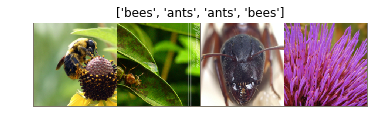

In [9]:
plot_pytorch_data_stream(data_hymenoptera['train'], max_images=4)

In [ ]:
data_hymenoptera_gray = create_dataset(HYMENOPTERA_GRAY_ROOT, batch_size=BATCH_SIZE, verbose=False)

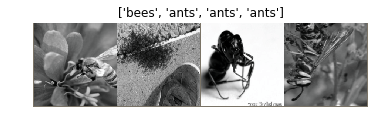

In [11]:
plot_pytorch_data_stream(data_hymenoptera_gray['train'], max_images=4)

In [12]:
data_simpsons = create_dataset(SIMPSONS_ROOT, batch_size=BATCH_SIZE*NUM_GPUS)

There are 20 clases in the dataset: {
    "abraham_grampa_simpson": 0,
    "apu_nahasapeemapetilon": 1,
    "bart_simpson": 2,
    "charles_montgomery_burns": 3,
    "chief_wiggum": 4,
    "comic_book_guy": 5,
    "edna_krabappel": 6,
    "homer_simpson": 7,
    "kent_brockman": 8,
    "krusty_the_clown": 9,
    "lenny_leonard": 10,
    "lisa_simpson": 11,
    "marge_simpson": 12,
    "mayor_quimby": 13,
    "milhouse_van_houten": 14,
    "moe_szyslak": 15,
    "ned_flanders": 16,
    "nelson_muntz": 17,
    "principal_skinner": 18,
    "sideshow_bob": 19
}
Sets sizes:  {
    "train": 15638,
    "val": 3910
}
Number of items in set train: {0: 730, 1: 498, 2: 1074, 3: 954, 4: 789, 5: 375, 6: 366, 7: 1797, 8: 398, 9: 965, 10: 248, 11: 1083, 12: 1033, 13: 197, 14: 863, 15: 1162, 16: 1163, 17: 286, 18: 955, 19: 702}
Number of items in set val: {0: 183, 1: 125, 2: 268, 3: 239, 4: 197, 5: 94, 6: 91, 7: 449, 8: 100, 9: 241, 10: 62, 11: 271, 12: 258, 13: 49, 14: 216, 15: 290, 16: 291, 17: 72, 

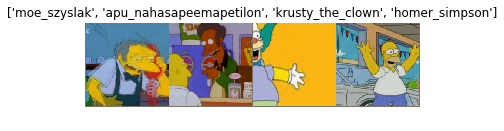

In [13]:
plot_pytorch_data_stream(data_simpsons['train'], max_images=4)

In [ ]:
data_simpsons_gray = create_dataset(SIMPSONS_GRAY_ROOT, batch_size=BATCH_SIZE*NUM_GPUS, verbose=False)

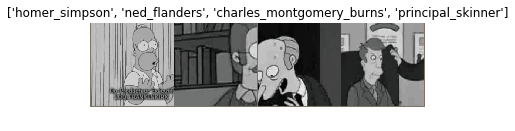

In [15]:
plot_pytorch_data_stream(data_simpsons_gray['train'], max_images=4)

In [16]:
data_dogs_vs_cats = create_dataset(DOGS_CATS_ROOT, batch_size=BATCH_SIZE*NUM_GPUS)

There are 2 clases in the dataset: {
    "cats": 0,
    "dogs": 1
}
Sets sizes:  {
    "train": 20000,
    "val": 5000
}
Number of items in set train: {0: 10000, 1: 10000}
Number of items in set val: {0: 2500, 1: 2500}


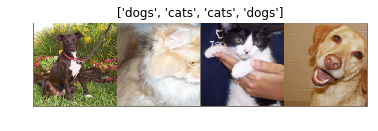

In [17]:
plot_pytorch_data_stream(data_dogs_vs_cats['train'], max_images=4)

In [ ]:
data_dogs_vs_cats_gray = create_dataset(DOGS_CATS_GRAY_ROOT, batch_size=BATCH_SIZE*NUM_GPUS, verbose=False)

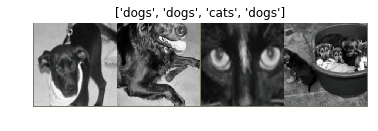

In [23]:
plot_pytorch_data_stream(data_dogs_vs_cats_gray['train'], max_images=4)

In [ ]:
data_caltech256 = create_dataset(CALTECH256_ROOT, batch_size=BATCH_SIZE*NUM_GPUS, verbose=False)

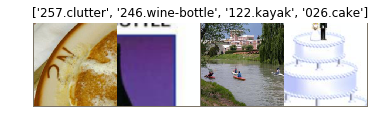

In [25]:
plot_pytorch_data_stream(data_caltech256['train'], max_images=4)

In [ ]:
data_caltech256_gray = create_dataset(CALTECH256_GRAY_ROOT, batch_size=BATCH_SIZE*NUM_GPUS, verbose=False)

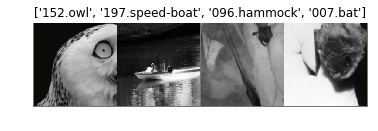

In [27]:
plot_pytorch_data_stream(data_caltech256_gray['train'], max_images=4)

## Training

For each dataset, we are going to compute finetunining and freeze and train. 

**NOTE:** As of now (Dec 2017), PyTorch implementation of parallel data computation is ineficient, so it takes almost the same time to compute finetuning and freezing with 4 GPUs. With 1 GPU freezing is around 2.5 faster than finetuning. They have a [PR](https://github.com/pytorch/pytorch/pull/4216) to solve this. For more info, please refer to this [issue](https://github.com/miguelgfierro/sciblog_support/issues/50).

In [41]:
val_acc_ft = "Validation accuracy finetuning"
val_acc_fr = "Validation accuracy freezing"
df = pd.DataFrame(columns=[val_acc_ft, val_acc_fr])


### Hymenoptera dataset

In [ ]:
model, metrics = finetune(data_hymenoptera, MODEL_NAME, SETS, EPOCHS, 1, LR, 
                          MOMENTUM, LR_STEP, LR_EPOCHS, verbose=False)

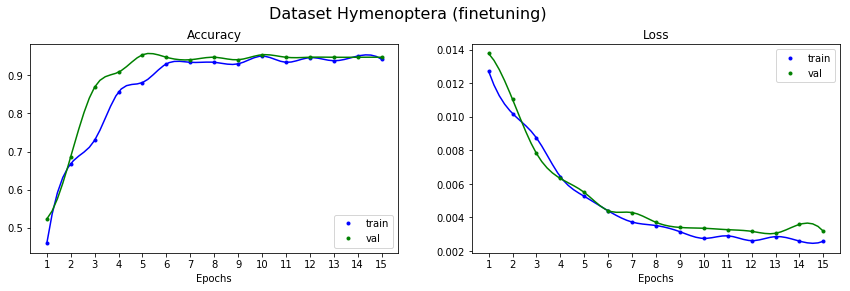

In [43]:
dataset_name = "Dataset Hymenoptera"
plot_metrics(metrics, dataset_name + " (finetuning)")
df.at[dataset_name, val_acc_ft] = max(metrics['val_acc'])

In [ ]:
model, metrics = freeze_and_train(data_hymenoptera, MODEL_NAME, SETS, EPOCHS, 1, LR, 
                                  MOMENTUM, LR_STEP, LR_EPOCHS, verbose=False)

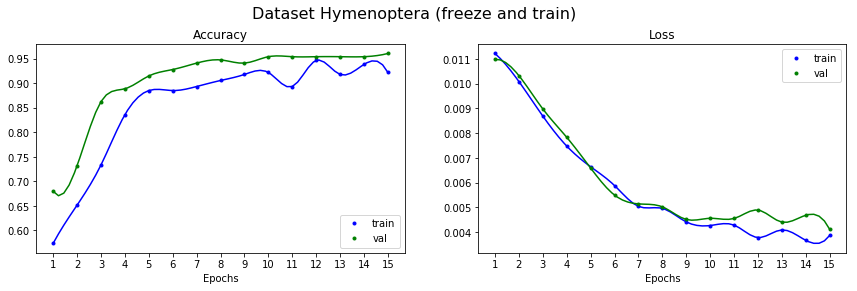

In [45]:
plot_metrics(metrics, dataset_name + " (freeze and train)")
df.at[dataset_name, val_acc_fr] = max(metrics['val_acc'])

In [ ]:
model, metrics = finetune(data_hymenoptera_gray, MODEL_NAME, SETS, EPOCHS, 1, LR, 
                          MOMENTUM, LR_STEP, LR_EPOCHS, verbose=False)

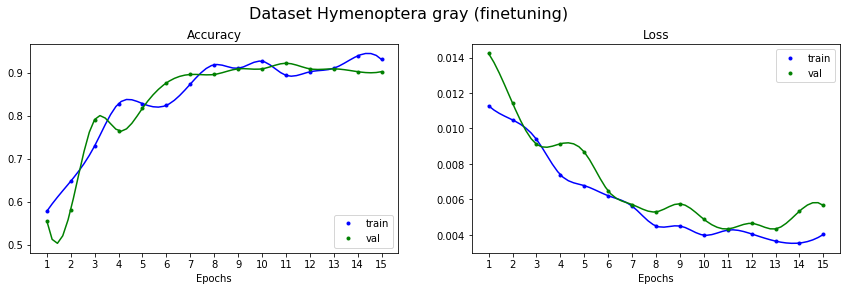

In [47]:
dataset_name = "Dataset Hymenoptera gray"
plot_metrics(metrics, dataset_name + " (finetuning)")
df.at[dataset_name, val_acc_ft] = max(metrics['val_acc'])

In [ ]:
model, metrics = freeze_and_train(data_hymenoptera_gray, MODEL_NAME, SETS, EPOCHS, 1, LR, 
                                  MOMENTUM, LR_STEP, LR_EPOCHS, verbose=False)

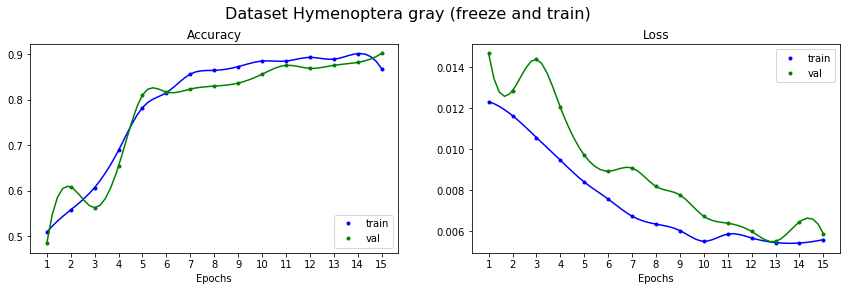

In [49]:
plot_metrics(metrics, dataset_name + " (freeze and train)")
df.at[dataset_name, val_acc_fr] = max(metrics['val_acc'])

### Simpsons dataset

In [ ]:
model, metrics = finetune(data_simpsons, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                          MOMENTUM, LR_STEP, LR_EPOCHS, verbose=False)

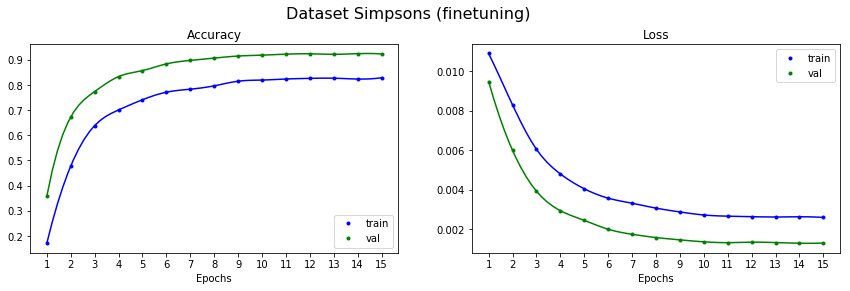

In [51]:
dataset_name = "Dataset Simpsons"
plot_metrics(metrics, dataset_name + " (finetuning)")
df.at[dataset_name, val_acc_ft] = max(metrics['val_acc'])

In [ ]:
model, metrics = freeze_and_train(data_simpsons, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                                  MOMENTUM, LR_STEP, LR_EPOCHS, verbose=False)

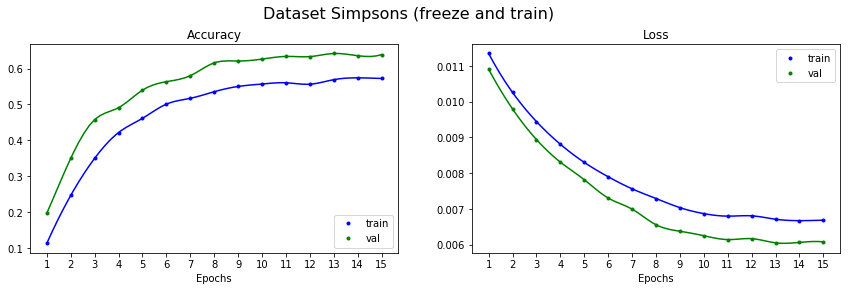

In [53]:
plot_metrics(metrics, dataset_name + " (freeze and train)")
df.at[dataset_name, val_acc_fr] = max(metrics['val_acc'])

In [ ]:
model, metrics = finetune(data_simpsons_gray, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                          MOMENTUM, LR_STEP, LR_EPOCHS, verbose=False)

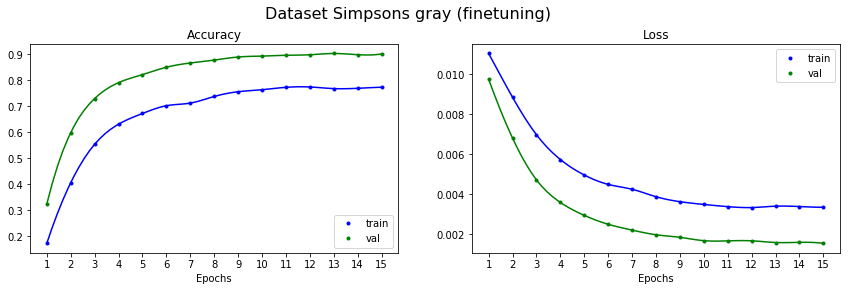

In [55]:
dataset_name = "Dataset Simpsons gray"
plot_metrics(metrics, dataset_name + " (finetuning)")
df.at[dataset_name, val_acc_ft] = max(metrics['val_acc'])

In [ ]:
model, metrics = freeze_and_train(data_simpsons_gray, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                                  MOMENTUM, LR_STEP, LR_EPOCHS, verbose=False)

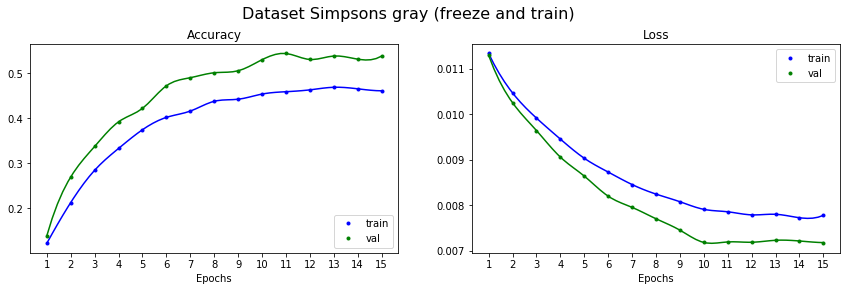

In [57]:
plot_metrics(metrics, dataset_name + " (freeze and train)")
df.at[dataset_name, val_acc_fr] = max(metrics['val_acc'])

### Dogs vs cats dataset

In [ ]:
model, metrics = finetune(data_dogs_vs_cats, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                          MOMENTUM, LR_STEP, LR_EPOCHS, verbose=False)

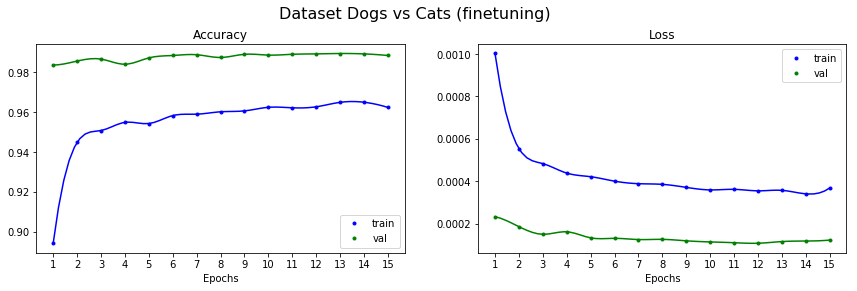

In [59]:
dataset_name = "Dataset Dogs vs Cats"
plot_metrics(metrics, dataset_name + " (finetuning)")
df.at[dataset_name, val_acc_ft] = max(metrics['val_acc'])

In [ ]:
model, metrics = freeze_and_train(data_dogs_vs_cats, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                                  MOMENTUM, LR_STEP, LR_EPOCHS, verbose=False)

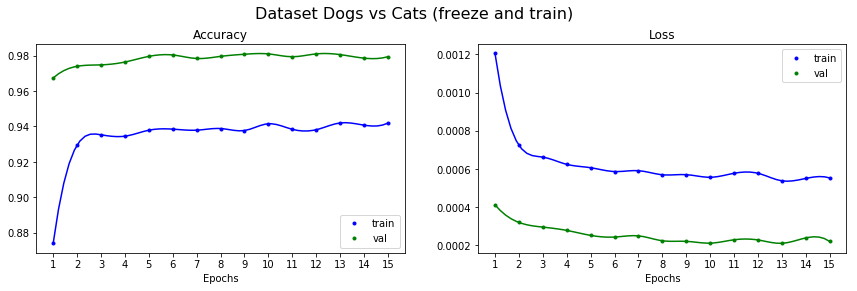

In [61]:
plot_metrics(metrics, dataset_name + " (freeze and train)")
df.at[dataset_name, val_acc_fr] = max(metrics['val_acc'])

In [ ]:
model, metrics = finetune(data_dogs_vs_cats_gray, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                          MOMENTUM, LR_STEP, LR_EPOCHS, verbose=False)

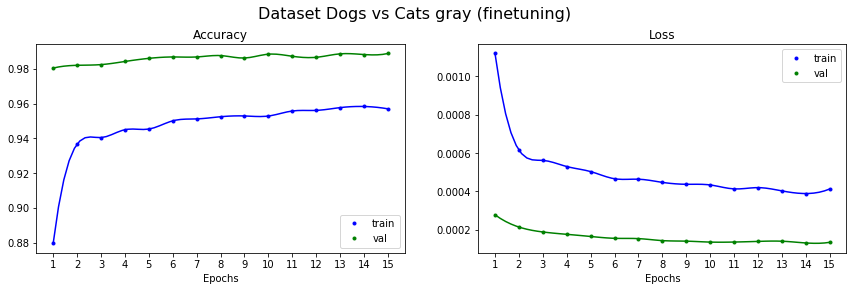

In [63]:
dataset_name = "Dataset Dogs vs Cats gray"
plot_metrics(metrics, dataset_name + " (finetuning)")
df.at[dataset_name, val_acc_ft] = max(metrics['val_acc'])

In [ ]:
model, metrics = freeze_and_train(data_dogs_vs_cats_gray, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                                  MOMENTUM, LR_STEP, LR_EPOCHS, verbose=False)

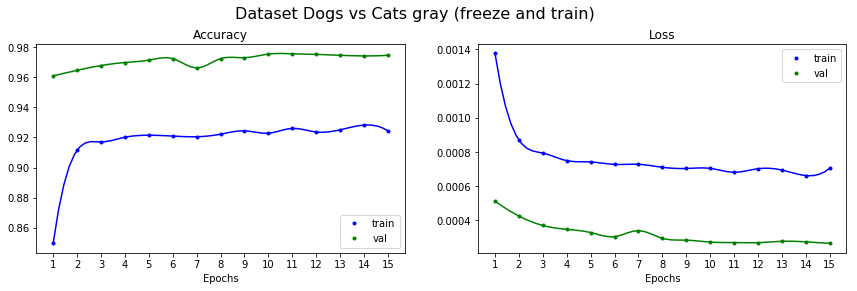

In [65]:
plot_metrics(metrics, dataset_name + " (freeze and train)")
df.at[dataset_name, val_acc_fr] = max(metrics['val_acc'])

### Caltech256 dataset

In [ ]:
model, metrics = finetune(data_caltech256, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                          MOMENTUM, LR_STEP, LR_EPOCHS, verbose=False)

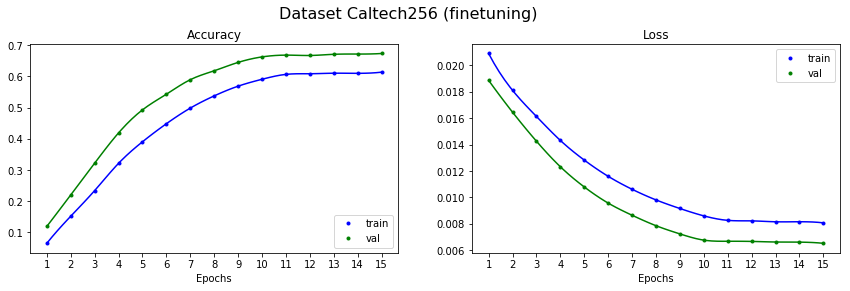

In [67]:
dataset_name = "Dataset Caltech256"
plot_metrics(metrics, dataset_name + " (finetuning)")
df.at[dataset_name, val_acc_ft] = max(metrics['val_acc'])

In [ ]:
model, metrics = freeze_and_train(data_caltech256, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                                  MOMENTUM, LR_STEP, LR_EPOCHS, verbose=False)

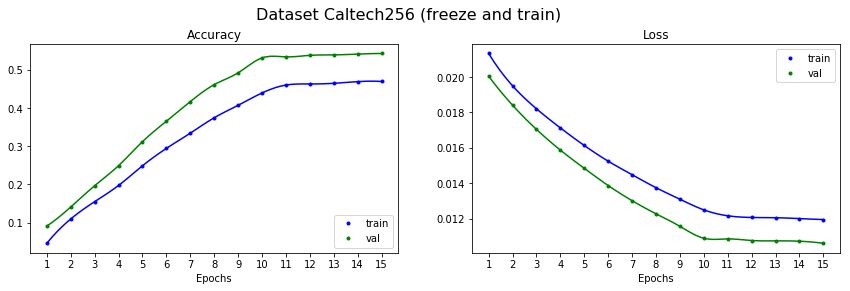

In [69]:
plot_metrics(metrics, dataset_name + " (freeze and train)")
df.at[dataset_name, val_acc_fr] = max(metrics['val_acc'])

In [ ]:
model, metrics = finetune(data_caltech256_gray, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                          MOMENTUM, LR_STEP, LR_EPOCHS, verbose=False)

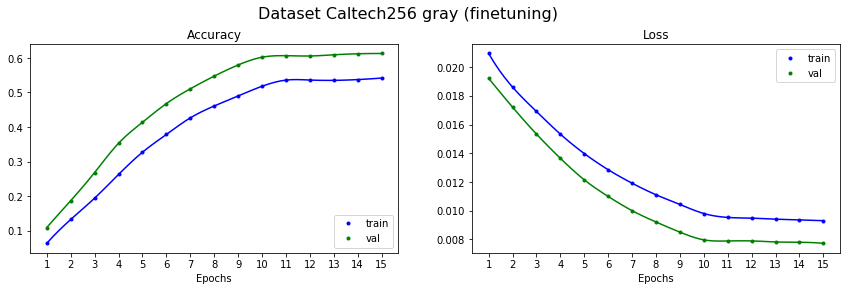

In [71]:
dataset_name = "Dataset Caltech256 gray"
plot_metrics(metrics, dataset_name + " (finetuning)")
df.at[dataset_name, val_acc_ft] = max(metrics['val_acc'])

In [ ]:
model, metrics = freeze_and_train(data_caltech256_gray, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                                  MOMENTUM, LR_STEP, LR_EPOCHS, verbose=False)

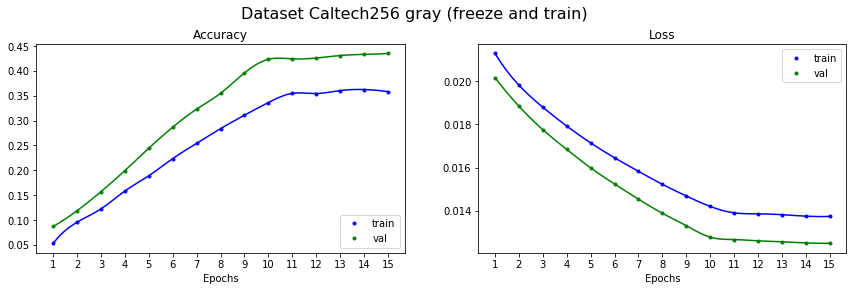

In [73]:
plot_metrics(metrics, dataset_name + " (freeze and train)")
df.at[dataset_name, val_acc_fr] = max(metrics['val_acc'])

### Summary

In [74]:
df

,Validation accuracy finetuning,Validation accuracy freezing
Dataset Hymenoptera,0.954248,0.960784
Dataset Hymenoptera gray,0.921569,0.901961
Dataset Simpsons,0.924552,0.641944
Dataset Simpsons gray,0.901535,0.543223
Dataset Dogs vs Cats,0.9894,0.981
Dataset Dogs vs Cats gray,0.9888,0.9756
Dataset Caltech256,0.673643,0.542511
Dataset Caltech256 gray,0.612819,0.434925


## Discussion and analysis

In this notebook we used a limited number of datasets with a small network, ResNet18, so it will be premature to generalize the findings to all datasets and networks. However, the findings may shed some light on the problem of when to use transfer learning. In the following table there is a summary of the results.

| Dataset | # of classes | # of images | Val. accuracy finetuning | Val. accuracy freezing |
| -- | :--: | :--: | :--: | :--: | 
| Dataset Hymenoptera | 2 | 397 | 0.954248 | 0.960784 |
| Dataset Hymenoptera gray | 2 | 397 | 0.921569 | 0.901961 |
| Dataset Simpsons | 20 | 19548 | 0.924552 | 0.641944 |
| Dataset Simpsons gray | 20 | 19548 | 0.901535 | 0.543223 |
| Dataset Dogs vs Cats | 2 | 25000 | 0.9894 | 0.981 |
| Dataset Dogs vs Cats gray | 2 | 25000 | 0.9888 | 0.9756 |
| Dataset Caltech256 | 257 | 30607 | 0.673643 | 0.542511 |
| Dataset Caltech256 gray | 257 | 30607 | 0.612819 | 0.434925 |

The first detail we observe is that degradation of accuracy when training a gray scale dataset in comparison with its color scale counterpart. This is consistent with the observation of other authors that the more different the domain between the base dataset and the target dataset, the worse the transference. 

We see as well that for Simpsons and Caltech256 datasets there is a high degradation when freezing. The highest degradation can be appreciated in Simpson dataset, which can be due to the fact that the domains are quite different, while in ImageNet there are natural images, in Simpsons the images have mostly plain colors. In Caltech we observe firstly a low accuracy, apart from a high degradation when freezing. Maybe the reason is because for a dataset of a high number of classes, the number of images per class is small, in the order of a couple of houndreds. 

The domain of dogs vs cats dataset is the closest to ImageNet, in fact, ImageNet contains several breeds of dogs and cats. In this case, there is no much difference when finetuning or freezing.

Finally, in the hymenoptera dataset we see a small improvement in the color dataset when freezing. This can be because the domain is closer and the dataset is small. In the grayscale counterpart we don't see an improvement when freezing, probably due to the domain difference. 

